## Measuring and Using Uncertainty in Bayesian Neural Networks

In this project, I investigate uncertainty in machine learning models using Bayesian Neural Networks (BNNs) implemented in PyMC. I start by testing a dense network on the MNIST dataset, where I evaluate the entropy and variance of the model’s predictions to assess uncertainty. After setting a threshold for uncertainty, I explore how these measures affect the model's performance and decision-making. Next, I apply the same approach to a convolutional neural network (CNN), achieving improved results and better uncertainty estimation. Additionally, I extend the experiments to a non-linear regression problem, further examining how uncertainty can be leveraged in regression tasks. These experiments demonstrate the potential of uncertainty-aware models in enhancing prediction reliability.

To evaluate uncertainty in our model, we first exclude at least one class from the dataset and train the model using only the remaining classes. This allows us to assess the model's uncertainty on the excluded class by leveraging the trained model's predictions on the known classes. Bayesian Neural Networks (BNNs) return a distribution of predictions for each sample, and we use these distributions to assess uncertainty.

For classification tasks, we calculate the entropy of the predicted probabilities, which is given by the following formula: $H(p) = - \sum_{i=1}^{C} p_i \log(p_i)$

This entropy measures the uncertainty of the predictions—the higher the entropy, the more uncertain the model is about its prediction.

We calculate the entropy for each sample across the known classes and for the excluded (unknown) classes. While we could compare the entropy distributions of both groups, doing so would not provide a fair evaluation since it would involve the unknown class predictions, which we are trying to assess. Therefore, instead of directly comparing these two distributions, we focus on the known classes. We set a threshold for uncertainty by selecting a percentile of certainty from the known classes—let's say the 95th percentile. This threshold is used to classify predictions as "certain" or "uncertain". If the entropy of a prediction falls above this threshold, we categorize the prediction as uncertain.

Following this approach, we recalculate the model's accuracy, adjusting for the instances where uncertainty exceeds the threshold. If the entropy surpasses the threshold, we consider the model as being unsure about the classification of that sample.

As a second approach, we use variance over the predicted probabilities instead of entropy. In this case, higher variance indicates greater confidence, as it means the model's predictions are more spread out. We follow a similar process, selecting a suitable threshold (for instance, the 95th percentile of variance) and adjusting the accuracy calculation based on the chosen threshold. This provides an alternative method for assessing uncertainty, where higher variance corresponds to more confident predictions.

# CLASSIFICATION

We will begin by experimenting with uncertainty in models for classification using Bayesian dense neural networks on the MNIST dataset. To start, we will test our methods on the MNIST dataset, excluding the '9' digit to evaluate the model's uncertainty when faced with unseen classes.

In [1]:
import numpy as np
import pymc as pm
import pytensor
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.datasets import load_digits
import pytensor as pt
import tensorflow as tf
import math
from scipy.stats import entropy
import pandas as pd
import torch
import torch.nn.functional as F
from scipy.stats import mode
import scipy
import arviz as az

floatX = pt.config.floatX
RANDOM_SEED = 9927
rng = np.random.default_rng(RANDOM_SEED)


Loading the dataset

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)
x_train = x_train.astype(floatX) / 255.0
x_test = x_test.astype(floatX) / 255.0

X_train = x_train.astype(floatX) # just to be sure
X_test = x_test.astype(floatX)
Y_train = y_train.astype(floatX)
Y_test = y_test.astype(floatX)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Removing 1 or multiple classes and renaming the labels accordingly

In [4]:
to_eliminate = np.array([9])
eliminate_mask_train = np.isin(Y_train, to_eliminate)
keep_mask_train = ~eliminate_mask_train

eliminate_mask_test = np.isin(Y_test, to_eliminate)
keep_mask_test = ~eliminate_mask_test

X_train_known = X_train[keep_mask_train]
Y_train_known = Y_train[keep_mask_train]

X_test_known = X_test[keep_mask_test]
Y_test_known = Y_test[keep_mask_test]

X_unknown = np.row_stack((X_train[eliminate_mask_train],X_test[eliminate_mask_test]))
Y_unknown = np.concatenate((Y_train[eliminate_mask_train], Y_test[eliminate_mask_test]))

n_classes = len(np.unique(Y_train_known))
remaining_classes = np.unique(Y_train_known)
class_mapping = {old_class: new_class for new_class, old_class in enumerate(remaining_classes)}
unknown_mapping = {to_eliminate[i]: n_classes+i for i in range(0, len(to_eliminate))}

Y_train_known = np.array([class_mapping[label] for label in Y_train_known]).astype(floatX)
Y_test_known = np.array([class_mapping[label] for label in Y_test_known]).astype(floatX)
Y_unknown = np.array([unknown_mapping[label] for label in Y_unknown]).astype(floatX)

## Model creation
 I prefer not to work with PyMC's new coords, it makes the code more readable at least for me. Additionally, I will use batching to avoid any potential memory issues.

In [281]:
def construct_nn_with_bias(ann_input, ann_output, batch_size=32):
    n_hidden_1 = 32
    n_hidden_2 = 64

    #initializations
    init_1 = np.random.randn(X_train.shape[1], n_hidden_1).astype(floatX)
    init_2 = np.random.randn(n_hidden_1, n_hidden_2).astype(floatX)
    init_out = np.random.randn(n_hidden_2, n_classes).astype(floatX)

    init_bias_1 = np.zeros(n_hidden_1).astype(floatX)
    init_bias_2 = np.zeros(n_hidden_2).astype(floatX)
    init_bias_out = np.zeros(n_classes).astype(floatX)

    # batching
    X_batch, Y_batch = pm.Minibatch(ann_input, ann_output, batch_size=batch_size)

    with pm.Model() as neural_network:
      # priors
      weights_in_1 = pm.Normal('w_in_1', 0, sigma=1, initval=init_1, shape=(X_train.shape[1], n_hidden_1))
      weights_1_2 = pm.Normal('w_1_2', 0, sigma=1, initval=init_2, shape=(n_hidden_1, n_hidden_2))
      weights_2_out = pm.Normal('w_2_out', 0, sigma=1, initval=init_out, shape=(n_hidden_2, n_classes))

      biases_1 = pm.Normal('b_1', 0, sigma=1, shape=(n_hidden_1,), initval=init_bias_1)
      biases_2 = pm.Normal('b_2', 0, sigma=1, shape=(n_hidden_2,), initval=init_bias_2)
      bias_out = pm.Normal('b_out', 0, sigma=1, shape=(n_classes,), initval=init_bias_out)

      # forward
      act_1 = pm.math.tanh(pm.math.dot(X_batch, weights_in_1) + biases_1)
      act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2) + biases_2)
      act_out = pm.math.softmax(pm.math.dot(act_2, weights_2_out) + bias_out, axis=1)

      out = pm.Categorical('out', p=act_out, observed=Y_batch, total_size=Y_train.shape[0])


    return neural_network


In [282]:
ann_input = pt.shared(X_train_known) # we have to make them shared to be able to change their values later for inference
ann_output = pt.shared(Y_train_known)
neural_network = construct_nn_with_bias(ann_input, ann_output, 64)

In [283]:
with neural_network:
    inference = pm.ADVI() # ADVI because we have a lot of data
    approx = pm.fit(n=50_000, method=inference, callbacks=[pm.callbacks.CheckParametersConvergence()])

Output()

To perform inference, we can take two approaches that yield the same results (aside from the randomness introduced by sampling). For both methods, we first need to sample from the posterior. The first approach is to estimate the posterior predictive using PyMC's built-in function sample_posterior_predictive. Since we worked with minibatching, we need to modify the model to accept the full dataset for inference (without retraining, just modifying for inference purposes).

In [284]:
n_draws = 500
trace = approx.sample(draws=n_draws)
with neural_network:
  pm.sample_posterior_predictive(trace, extend_inferencedata=True)
  trace.posterior = pm.compute_deterministics(trace.posterior, merge_dataset=True) # posterior sampling

Output()

Output()

### First method

To be able to do inference on full sets of data we have to rewrite the model without the batching part, we won't have to retrain anything, just copy paste and remove the batching variables

In [285]:
with pm.Model() as with_out_batch:
    n_hidden_1 = 32
    n_hidden_2 = 64

    init_1 = np.random.randn(X_train.shape[1], n_hidden_1).astype(floatX)
    init_2 = np.random.randn(n_hidden_1, n_hidden_2).astype(floatX)
    init_out = np.random.randn(n_hidden_2, n_classes).astype(floatX)

    init_bias_1 = np.zeros(n_hidden_1).astype(floatX)
    init_bias_2 = np.zeros(n_hidden_2).astype(floatX)
    init_bias_out = np.zeros(n_classes).astype(floatX)


    weights_in_1 = pm.Normal('w_in_1', 0, sigma=1, shape=(X_train.shape[1], n_hidden_1), initval=init_1)
    weights_1_2 = pm.Normal('w_1_2', 0, sigma=1, shape=(n_hidden_1, n_hidden_2), initval=init_2)
    weights_2_out = pm.Normal('w_2_out', 0, sigma=1, shape=(n_hidden_2, n_classes), initval=init_out)

    biases_1 = pm.Normal('b_1', 0, sigma=1, shape=(n_hidden_1,), initval=init_bias_1)
    biases_2 = pm.Normal('b_2', 0, sigma=1, shape=(n_hidden_2,), initval=init_bias_2)
    bias_out = pm.Normal('b_out', 0, sigma=1, shape=(n_classes,), initval=init_bias_out)

    act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1) + biases_1)
    act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2) + biases_2)
    act_out = pm.math.softmax(pm.math.dot(act_2, weights_2_out) + bias_out, axis=1)

    out = pm.Categorical('out', p=act_out, observed=ann_output, total_size=Y_train.shape[0])


In [267]:
with with_out_batch: # because the ann_input and ann_output are shared variables we can set their values tot he test set
  ann_input.set_value(X_test_known)
  ann_output.set_value(np.zeros(X_test_known.shape[0])) # we have to make a dummy output
  ppc = pm.sample_posterior_predictive(trace)


Output()

Once we have the posterior predictive, we can extract the results from the categorical distribution, count the frequency of each outcome, select the "majority" prediction, and compare it to the true labels.



In [291]:
results = ppc.posterior_predictive['out'].values[0]
max_value = np.max(results)
# preds = np.argmax(np.apply_along_axis(lambda row: np.bincount(row, minlength=max_value + 1), axis=1, arr=results.T), axis=1) # we can count, take probabilities and check the highest probability
pred = stats.mode(results, axis=0)[0] # or we can just take the mode
accuracy = (Y_test_known == pred).mean()
print(f"Accuracy = {accuracy * 100:.2f}%")

Accuracy = 92.33%


## Second method:
The second approach involves extracting all the weights from the posterior and performing the forward step manually. At this point, we no longer rely on PyMC; instead, we can use libraries like NumPy or others for the computation. The downside is that if the architecture changes, we may need to adjust the forward step accordingly. The advantage, however, is that we have full control over the process, and if the inference computation becomes time-consuming, we can utilize the GPU to speed up the calculation.

In [ ]:
weights_in_1_samples = trace.posterior['w_in_1'].values[0]
weights_1_2_samples = trace.posterior['w_1_2'].values[0]
weights_2_out_samples = trace.posterior['w_2_out'].values[0]
biases_1_samples = trace.posterior['b_1'].values[0]
biases_2_samples = trace.posterior['b_2'].values[0]
bias_out_samples = trace.posterior['b_out'].values[0]

all_params = [
    [weights_in_1_samples[i], weights_1_2_samples[i], weights_2_out_samples[i],
     biases_1_samples[i], biases_2_samples[i], bias_out_samples[i]]
    for i in range(weights_in_1_samples.shape[0])  # Loop over draws
]

def softmax(x, axis=-1):
    e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

def forward(x, all_params):
    actouts = []
    for params in all_params:
        w1, w2, wo, b1, b2, bo = params

        act1 = np.tanh(np.dot(x, w1) + b1)
        act2 = np.tanh(np.dot(act1, w2) + b2)
        actout = np.dot(act2, wo) + bo
        actout = softmax(actout, axis=-1)
        actouts.append(actout)

    return np.array(actouts)

In [290]:
softmaxes = forward(X_test_known, all_params)

predicted_classes = np.argmax(softmaxes, axis=-1)
predictions = mode(predicted_classes)[0]
print(f"Accuracy: {np.mean(predictions == Y_test_known)}")

Accuracy: 0.9076854632410188


Now that we know how to do inference using both methods, we can choose one and start our experiments for uncertainty. For this part, i will use the first method, approximating directely the posterior predictive

## Prediction uncertainty

In [286]:
# we redo the calculations from the known classes for readability
with with_out_batch:
  ann_input.set_value(X_test_known)
  ann_output.set_value(np.zeros(X_test_known.shape[0]))
  ppc = pm.sample_posterior_predictive(trace)

# Now we do the same thing for the unknown labels
with with_out_batch:
  ann_input.set_value(X_unknown)
  ann_output.set_value(np.zeros(X_unknown.shape[0]))
  ppc_unknown = pm.sample_posterior_predictive(trace)

Output()

Output()

In [287]:
results = ppc.posterior_predictive['out'].values[0].T # we take the results, we will have n predictions for each image
results_unknown = ppc_unknown.posterior_predictive['out'].values[0].T

probs = np.apply_along_axis(lambda row: np.bincount(row, minlength = n_classes), arr=results, axis=1)/n_draws  # calculating each frequency and transforming in probabilities
probs_unknown = np.apply_along_axis(lambda row: np.bincount(row, minlength = n_classes), arr=results_unknown, axis=1)/n_draws


Now that we have the probabilities of the classes predictions, we can compute the entropy and/or the variance

In [288]:
entropies_known = entropy(probs,axis=1)
entropies_unknown = entropy(probs_unknown,axis=1)
var_known = np.var(probs,axis=1)
var_unknown = np.var(probs_unknown,axis=1)

To measure uncertainty, one option is to compare the entropy distribution of known labels with that of the unknown classes. However, this approach isn't entirely "fair" as it assumes access to some unknown labels. Instead, we can take another approach by focusing only on the entropy distribution of the known classes and setting a threshold based on their distribution. For example, we can use the nth percentile, meaning that predictions with entropy below this threshold will be considered confident, while those above it will indicate uncertainty.

If the model has been trained effectively, we would expect the entropy of the unknown labels to mostly fall above this threshold.



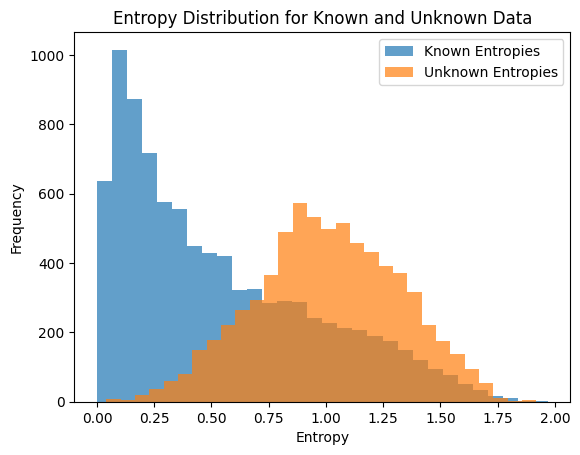

Uncertain samples in known data: 989
Uncertain samples in unknown data: 2280


In [289]:
plt.hist(entropies_known, bins=30, alpha=0.7, label="Known Entropies")
plt.hist(entropies_unknown, bins=30, alpha=0.7, label="Unknown Entropies")
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.legend()
plt.title("Entropy Distribution for Known and Unknown Data")
plt.show()
uncertainty_threshold = np.percentile(entropies_known, 89)  #  89-th percentile

uncertain_samples_known = entropies_known > uncertainty_threshold
uncertain_samples_unknown = entropies_unknown > uncertainty_threshold

print(f"Uncertain samples in known data: {np.sum(uncertain_samples_known)}")
print(f"Uncertain samples in unknown data: {np.sum(uncertain_samples_unknown)}")


In [292]:
predictions_copy = pred.copy()
predictions_copy[entropies_known > uncertainty_threshold]=-1
print(f"Accuracy of unknowns {np.sum(uncertain_samples_unknown)/len(Y_unknown)}")
print(f"Accuracy after verifying uncertainty on test data {np.mean(predictions_copy==Y_test_known)}")

Accuracy of unknowns 0.3276803679218166
Accuracy after verifying uncertainty on test data 0.8585251918585252


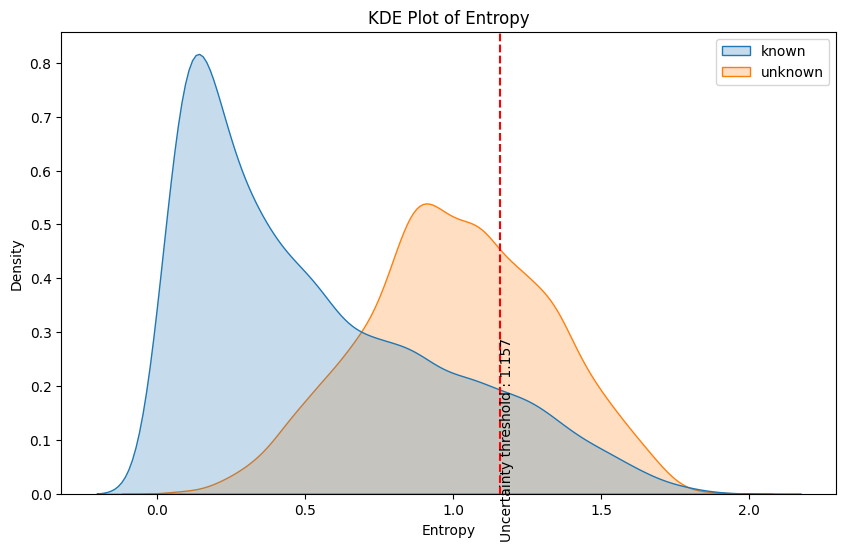

In [293]:
from scipy.stats import gaussian_kde
import seaborn as sns
entropies_full = np.concatenate((entropies_known, entropies_unknown)) # we combine them for a better looking plot
all_y_test = np.concatenate([Y_test_known, Y_unknown])
all_y_test = np.array(["known" if i < n_classes else "unknown" for i in all_y_test])

kde_known = gaussian_kde(entropies_full[np.array(all_y_test) == "known"])
kde_unknown = gaussian_kde(entropies_full[np.array(all_y_test) == "unknown"])

uncertainty_threshold = np.percentile(entropies_known, 89)  #
plt.figure(figsize = (10, 6))
sns.kdeplot(x = entropies_full, hue = all_y_test, fill = True)
plt.axvline(uncertainty_threshold, color = "red", linestyle = "--")
plt.text(uncertainty_threshold, 0.1,
         f"Uncertainty threshold : {uncertainty_threshold:.3f}",
         rotation = 90, verticalalignment = "center")
plt.title("KDE Plot of Entropy")
plt.xlabel("Entropy")
plt.ylabel("Density")
plt.show()

Now we try with variance

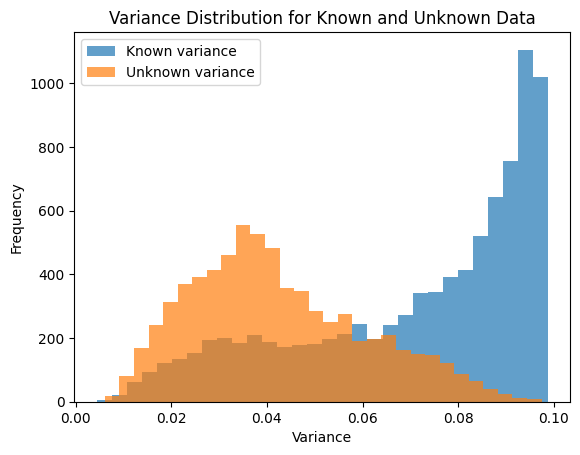

Uncertain samples in known data: 989
Uncertain samples in unknown data: 2348


In [294]:
plt.hist(var_known, bins=30, alpha=0.7, label="Known variance")
plt.hist(var_unknown, bins=30, alpha=0.7, label="Unknown variance")
plt.xlabel("Variance")
plt.ylabel("Frequency")
plt.legend()
plt.title("Variance Distribution for Known and Unknown Data")
plt.show()
uncertainty_threshold = np.percentile(var_known, 100-89)  #  89-th percentile

uncertain_samples_known = var_known < uncertainty_threshold
uncertain_samples_unknown = var_unknown < uncertainty_threshold

print(f"Uncertain samples in known data: {np.sum(uncertain_samples_known)}")
print(f"Uncertain samples in unknown data: {np.sum(uncertain_samples_unknown)}")


In [295]:
predictions_copy = predictions.copy()
predictions_copy[var_known < uncertainty_threshold]=-1
print(f"Accuracy of unknowns {np.sum(uncertain_samples_unknown)/len(Y_unknown)}")
print(f"Accuracy after verifying uncertainty on test data {np.mean(predictions_copy==Y_test_known)}")

Accuracy of unknowns 0.33745329117562517
Accuracy after verifying uncertainty on test data 0.8521855188521855


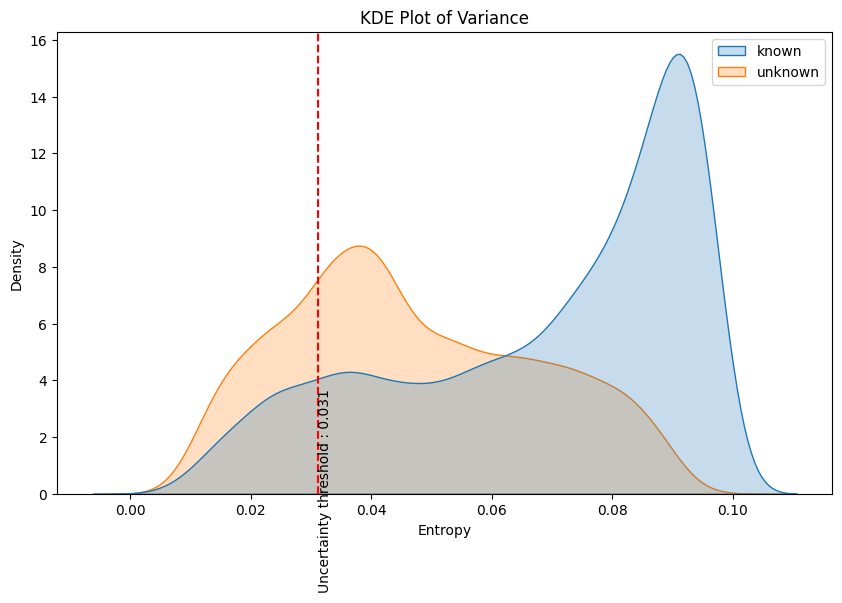

In [280]:
from scipy.stats import gaussian_kde
import seaborn as sns
var_full = np.concatenate((var_known, var_unknown)) # we combine them for a better looking plot
all_y_test = np.concatenate([Y_test_known, Y_unknown])
all_y_test = np.array(["known" if i < n_classes else "unknown" for i in all_y_test])

kde_known = gaussian_kde(var_full[np.array(all_y_test) == "known"])
kde_unknown = gaussian_kde(var_full[np.array(all_y_test) == "unknown"])

uncertainty_threshold = np.percentile(var_known, 100-89)  #
plt.figure(figsize = (10, 6))
sns.kdeplot(x = var_full, hue = all_y_test, fill = True)
plt.axvline(uncertainty_threshold, color = "red", linestyle = "--")
plt.text(uncertainty_threshold, 0.1,
         f"Uncertainty threshold : {uncertainty_threshold:.3f}",
         rotation = 90, verticalalignment = "center")
plt.title("KDE Plot of Variance")
plt.xlabel("Entropy")
plt.ylabel("Density")
plt.show()

The results are satisfactory, and we can adjust the threshold based on what aspect of the model's performance is most important to us. There is a clear trade-off between the model's ability to accurately recognize that the target class was not present during training and its accuracy on the known classes. This balance allows us to prioritize uncertainty detection or classification performance depending on the use case.

One possible reason the model does not perform exceptionally well is that a dense architecture struggles to capture spatial features in the images that convolutional layers are specifically designed to learn. To address this limitation, we will implement a Bayesian convolutional neural network (CNN) architecture to determine whether it can improve the model's predictions and better handle uncertainty.

For this, we will use the same approach as before. Fortunately, PyMC includes a convolution function implemented in PyTensor, which serves as the backend for most of PyMC's functionality. It is worth noting that PyTensor offers two implementations for these functions. For the faster option (as of today ~ january 2025), PyTensor must be installed locally and include "from tests.tensor.conv.test_abstract_conv import conv2d_corr as conv2d"



In [87]:
from pytensor.tensor import conv
import pytensor.tensor as T

def relu(x):
    return T.maximum(0., x)
def leakyrelu(x, coef=0.1):
    return T.maximum(x*coef, x)

def apply_conv2d_batch_norm(X_batch, weights_conv, bias, gamma, beta, stride, activation = T.tanh, border_mode='half', convol2d=conv.conv2d): # convolution + batch normalization

  conv_out = convol2d(X_batch, weights_conv, border_mode=border_mode, subsample=(stride,stride))

  mean = conv_out.mean(axis=(0, 2, 3), keepdims=True)
  variance = ((conv_out - mean) ** 2).mean(axis=(0, 2, 3), keepdims=True)
  normalized = (conv_out - mean) / T.sqrt(variance + 1e-5)

  batchnorm_out = gamma.dimshuffle('x', 0, 'x', 'x') * normalized + beta.dimshuffle('x', 0, 'x', 'x')

  image_out = activation(batchnorm_out + bias.dimshuffle('x', 0, 'x', 'x'))

  return image_out

In [ ]:
from tests.tensor.conv.test_abstract_conv import conv2d_corr as conv2d # only if you have Pytensor installed locally

In [242]:
import numpy as np
import pymc as pm

def construct_cnn(ann_input, ann_output, batch_size=32, n_classes=10):
    n_filters_1 = 16
    n_filters_2 = 32

    n_conv_layers = 2

    filter_size = 3
    channels = ann_input.shape[1].eval()
    stride = 2
    after_conv_shape = n_filters_2 * (np.ceil(ann_input.eval().shape[2] / stride**n_conv_layers).astype(int) ** 2) # you have to compute it here otherwise, if you "cheat" by taking it from the last conv layer, the posterior predictive will skip it and give bad results
    # a trick if if fails is to look at the error message and take the correct value from there

    filters_1 = np.random.randn(n_filters_1, channels, filter_size, filter_size).astype(floatX)
    filters_2 = np.random.randn(n_filters_2, n_filters_1, filter_size, filter_size).astype(floatX)

    init_bias_1 = np.zeros(n_filters_1).astype(floatX)
    init_bias_2 = np.zeros(n_filters_2).astype(floatX)

    init_out = np.random.randn(after_conv_shape, n_classes).astype(floatX)
    init_bias_out = np.zeros(n_classes).astype(floatX)

    X_batch, Y_batch = pm.Minibatch(ann_input, ann_output, batch_size=batch_size)

    with pm.Model() as neural_network:
        gamma_1 = pm.Normal('gamma', 1, 1, shape=(n_filters_1,), initval=np.ones(n_filters_1))
        beta_1 = pm.Normal('beta', 0, 1, shape=(n_filters_1,), initval=np.zeros(n_filters_1))
        gamma_2 = pm.Normal('gamma_2', 1, 1, shape=(n_filters_2,), initval=np.ones(n_filters_2))
        beta_2 = pm.Normal('beta_2', 0, 1, shape=(n_filters_2,), initval=np.zeros(n_filters_2))


        weights_conv = pm.Normal('w_cnn', 0, 1, size=(n_filters_1, channels, filter_size, filter_size), initval=filters_1)
        weights_conv_2 = pm.Normal('w_cnn_2', 0, 1, size=(n_filters_2, n_filters_1, filter_size, filter_size), initval=filters_2)

        bias_conv = pm.Normal('b_cnn', 0, 1, shape=(n_filters_1,), initval=init_bias_1)
        bias_conv_2 = pm.Normal('b_cnn_2', 0, 1, shape=(n_filters_2,), initval=init_bias_2)
        bias_out = pm.Normal('b_out', 0, sigma=1, shape=(n_classes,), initval=init_bias_out)

        weights_1_out = pm.Normal('w_2_out', 0, sigma=1, initval=init_out, shape=(after_conv_shape , n_classes))


        conv_out = apply_conv2d_batch_norm(X_batch, weights_conv, bias_conv, gamma_1, beta_1, stride, activation=leakyrelu, convol2d = conv2d)
        conv_out_2 = apply_conv2d_batch_norm(conv_out, weights_conv_2, bias_conv_2, gamma_2, beta_2, stride, activation=leakyrelu, convol2d = conv2d)

        conv_out_flat = T.flatten(conv_out_2, 2)
        act_out = pm.math.softmax(pm.math.dot(conv_out_flat, weights_1_out) + bias_out, axis=1)
        out = pm.Categorical('out', p=act_out, observed=Y_batch, total_size=Y_train.shape[0])

    return neural_network


Now we redo the process as before

In [243]:
ann_input = pt.shared(X_train_known.reshape(-1, 1, 28, 28))
ann_output = pt.shared(Y_train_known)
neural_network = construct_cnn(ann_input, ann_output, 32, n_classes = n_classes)
with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=50_000, method=inference, callbacks=[pm.callbacks.CheckParametersConvergence()])

Output()

In [244]:
with pm.Model() as with_out_batch:
    n_filters_1 = 16
    n_filters_2 = 32

    n_conv_layers = 2

    filter_size = 3
    channels = ann_input.shape[1].eval()
    stride = 2
    after_conv_shape = n_filters_2 * (np.ceil(ann_input.eval().shape[2] / stride**n_conv_layers).astype(int) ** 2) # you have to compute it here otherwise, if you "cheat" by taking it from the last conv layer, the posterior predictive will skip it and give bad results

    #init
    filters_1 = np.random.randn(n_filters_1, channels, filter_size, filter_size).astype(floatX)
    filters_2 = np.random.randn(n_filters_2, n_filters_1, filter_size, filter_size).astype(floatX)

    init_bias_1 = np.zeros(n_filters_1).astype(floatX)
    init_bias_2 = np.zeros(n_filters_2).astype(floatX)

    init_out = np.random.randn(after_conv_shape, n_classes).astype(floatX)
    init_bias_out = np.zeros(n_classes).astype(floatX)

    gamma_1 = pm.Normal('gamma', 1, 1, shape=(n_filters_1,), initval=np.ones(n_filters_1))
    beta_1 = pm.Normal('beta', 0, 1, shape=(n_filters_1,), initval=np.zeros(n_filters_1))
    gamma_2 = pm.Normal('gamma_2', 1, 1, shape=(n_filters_2,), initval=np.ones(n_filters_2))
    beta_2 = pm.Normal('beta_2', 0, 1, shape=(n_filters_2,), initval=np.zeros(n_filters_2))

    weights_conv = pm.Normal('w_cnn', 0, 1, size=(n_filters_1, channels, filter_size, filter_size), initval=filters_1)
    weights_conv_2 = pm.Normal('w_cnn_2', 0, 1, size=(n_filters_2, n_filters_1, filter_size, filter_size), initval=filters_2)

    bias_conv = pm.Normal('b_cnn', 0, 1, shape=(n_filters_1,), initval=init_bias_1)
    bias_conv_2 = pm.Normal('b_cnn_2', 0, 1, shape=(n_filters_2,), initval=init_bias_2)
    bias_out = pm.Normal('b_out', 0, sigma=1, shape=(n_classes,), initval=init_bias_out)

    weights_1_out = pm.Normal('w_2_out', 0, sigma=1, initval=init_out, shape=(after_conv_shape , n_classes))


    conv_out = apply_conv2d_batch_norm(ann_input, weights_conv, bias_conv, gamma_1, beta_1, stride, activation=leakyrelu, convol2d=conv2d)
    conv_out_2 = apply_conv2d_batch_norm(conv_out, weights_conv_2, bias_conv_2, gamma_2, beta_2, stride, activation=leakyrelu, convol2d=conv2d)

    conv_out_flat = T.flatten(conv_out_2, 2)
    act_out = pm.math.softmax(pm.math.dot(conv_out_flat, weights_1_out) + bias_out, axis=1)
    out = pm.Categorical('out', p=act_out, observed=ann_output, total_size=Y_train.shape[0])



In [245]:
n_draws = 100
trace = approx.sample(draws=n_draws)
with neural_network:
  pm.sample_posterior_predictive(trace, extend_inferencedata=True)
  trace.posterior = pm.compute_deterministics(trace.posterior, merge_dataset=True)


Output()

Output()

In [246]:
with with_out_batch:
  ann_input.set_value(X_test_known.reshape(-1, 1, 28, 28))
  ann_output.set_value(np.zeros(X_test_known.shape[0]))
  ppck = pm.sample_posterior_predictive(trace)

results = ppck.posterior_predictive['out'].values[0]
max_value = np.max(results)
preds = np.argmax(np.apply_along_axis(lambda row: np.bincount(row, minlength=max_value + 1), axis=1, arr=results.T), axis=1)
pred = stats.mode(results, axis=0)[0]
accuracy = (Y_test_known == pred).mean()
print(f"Accuracy = {accuracy * 100:.2f}%")
with with_out_batch:
  ann_input.set_value(X_unknown.reshape(-1, 1, 28, 28 ))
  ann_output.set_value(np.zeros(X_unknown.shape[0]))
  ppc_unknown = pm.sample_posterior_predictive(trace)

Output()

Accuracy = 94.71%


Output()

In [247]:
results = ppck.posterior_predictive['out'].values[0].T
results_unknown = ppc_unknown.posterior_predictive['out'].values[0].T
probs = np.apply_along_axis(lambda row: np.bincount(row, minlength = n_classes), arr=results, axis=1)/n_draws
probs_unknown = np.apply_along_axis(lambda row: np.bincount(row, minlength = n_classes), arr=results_unknown, axis=1)/n_draws


In [248]:
entropies_known = entropy(probs,axis=1)
entropies_unknown = entropy(probs_unknown,axis=1)
var_known = np.var(probs,axis=1)
var_unknown = np.var(probs_unknown,axis=1)

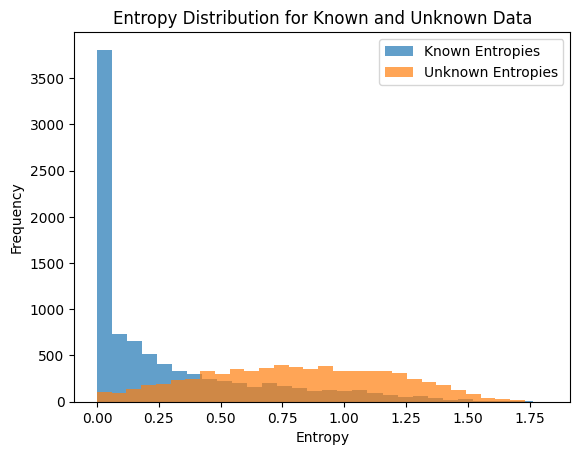

Uncertain samples in known data: 1168
Uncertain samples in unknown data: 3928


In [249]:
plt.hist(entropies_known, bins=30, alpha=0.7, label="Known Entropies")
plt.hist(entropies_unknown, bins=30, alpha=0.7, label="Unknown Entropies")
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.legend()
plt.title("Entropy Distribution for Known and Unknown Data")
plt.show()
uncertainty_threshold = np.percentile(entropies_known, 87)  #

uncertain_samples_known = entropies_known > uncertainty_threshold
uncertain_samples_unknown = entropies_unknown > uncertainty_threshold

print(f"Uncertain samples in known data: {np.sum(uncertain_samples_known)}")
print(f"Uncertain samples in unknown data: {np.sum(uncertain_samples_unknown)}")


In [251]:
predictions_copy = preds.copy()
predictions_copy[entropies_known > uncertainty_threshold]=-1
print(f"Accuracy of unknowns {np.sum(uncertain_samples_unknown)/len(Y_unknown)}")
print(f"Accuracy after verifying uncertainty on test data {np.mean(predictions_copy==Y_test_known)}")

Accuracy of unknowns 0.5645300373670595
Accuracy after verifying uncertainty on test data 0.8565231898565232


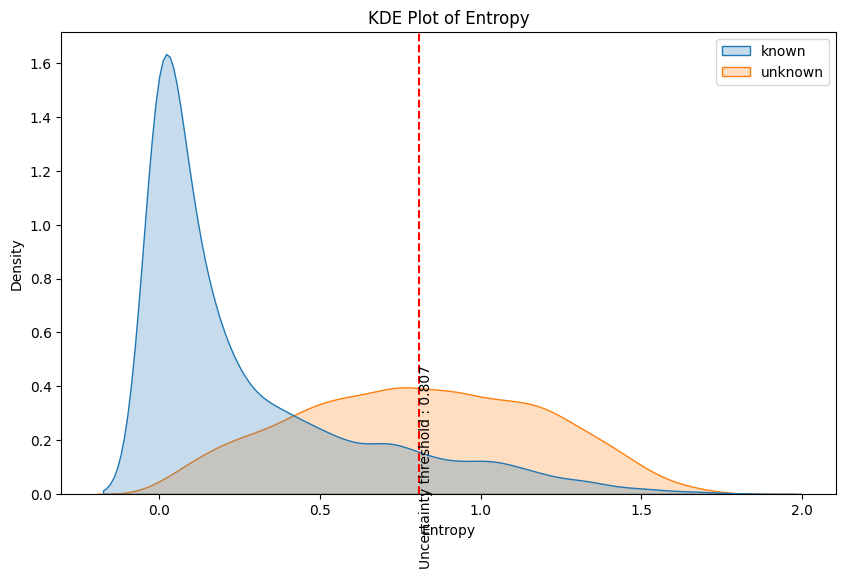

In [252]:
from scipy.stats import gaussian_kde
import seaborn as sns
entropies_full = np.concatenate((entropies_known, entropies_unknown)) # we combine them for a better looking plot
all_y_test = np.concatenate([Y_test_known, Y_unknown])
all_y_test = np.array(["known" if i < n_classes else "unknown" for i in all_y_test])

kde_known = gaussian_kde(entropies_full[np.array(all_y_test) == "known"])
kde_unknown = gaussian_kde(entropies_full[np.array(all_y_test) == "unknown"])

uncertainty_threshold = np.percentile(entropies_known, 89)  #
plt.figure(figsize = (10, 6))
sns.kdeplot(x = entropies_full, hue = all_y_test, fill = True)
plt.axvline(uncertainty_threshold, color = "red", linestyle = "--")
plt.text(uncertainty_threshold, 0.1,
         f"Uncertainty threshold : {uncertainty_threshold:.3f}",
         rotation = 90, verticalalignment = "center")
plt.title("KDE Plot of Entropy")
plt.xlabel("Entropy")
plt.ylabel("Density")
plt.show()

We can plot the images and predict with uncertainty

In [256]:
def plot_and_predict(img, entropy_threshold = None):
  plt.imshow(img.reshape(28, 28))
  if(entropy_threshold == None):
    print("NO THRESHOLD PROVIDED")
    return ;
  with with_out_batch:
    ann_input.set_value(img.reshape(1, 1, 28, 28 ))
    ann_output.set_value(np.zeros(1))
    ppc = pm.sample_posterior_predictive(trace, progressbar=False)
  result = ppc.posterior_predictive['out'][0].values
  prob1 = np.bincount(result.flatten())/100
  entr = entropy(prob1)
  if(entr > entropy_threshold):
    print(entr)
    print("UNKNOWN LABEL")
  else:
    print(f"PREDICTED AS {mode(result)[0][0]} with entropy {entr} and probability {prob1[np.argmax(prob1)]}")


1.5533282802949113
UNKNOWN LABEL


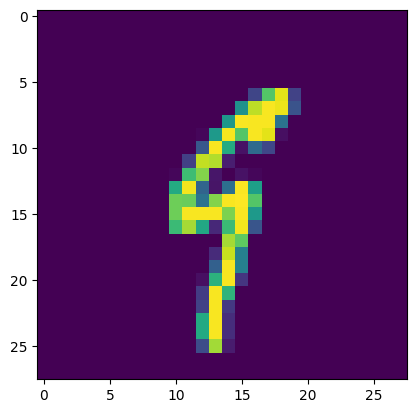

In [254]:
plot_and_predict(X_unknown[4500], uncertainty_threshold)

PREDICTED AS 7 with entropy 0.0 and probability 1.0


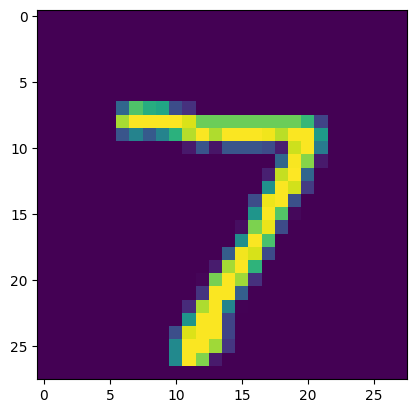

In [257]:
plot_and_predict(X_test_known[0], uncertainty_threshold)

Now, again we check variance method as well

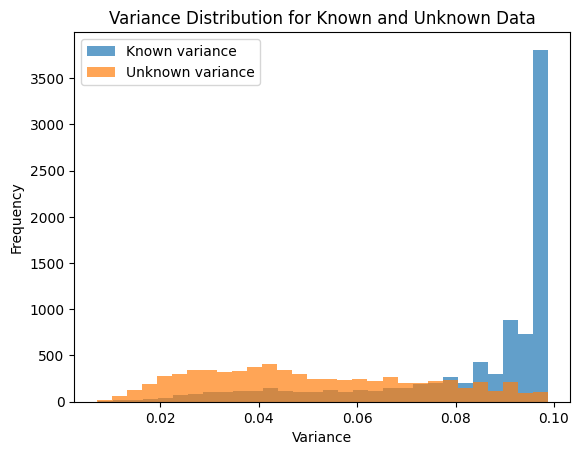

Uncertain samples in known data: 989
Uncertain samples in unknown data: 3477


In [258]:
plt.hist(var_known, bins=30, alpha=0.7, label="Known variance")
plt.hist(var_unknown, bins=30, alpha=0.7, label="Unknown variance")
plt.xlabel("Variance")
plt.ylabel("Frequency")
plt.legend()
plt.title("Variance Distribution for Known and Unknown Data")
plt.show()
uncertainty_threshold = np.percentile(var_known, 100-89)  #  89-th percentile

uncertain_samples_known = var_known < uncertainty_threshold
uncertain_samples_unknown = var_unknown < uncertainty_threshold

print(f"Uncertain samples in known data: {np.sum(uncertain_samples_known)}")
print(f"Uncertain samples in unknown data: {np.sum(uncertain_samples_unknown)}")


In [260]:
predictions_copy = preds.copy()
predictions_copy[var_known < uncertainty_threshold]=-1
print(f"Accuracy of unknowns {np.sum(uncertain_samples_unknown)/len(Y_unknown)}")
print(f"Accuracy after verifying uncertainty on test data {np.mean(predictions_copy==Y_test_known)}")

Accuracy of unknowns 0.49971256108077033
Accuracy after verifying uncertainty on test data 0.8758758758758759


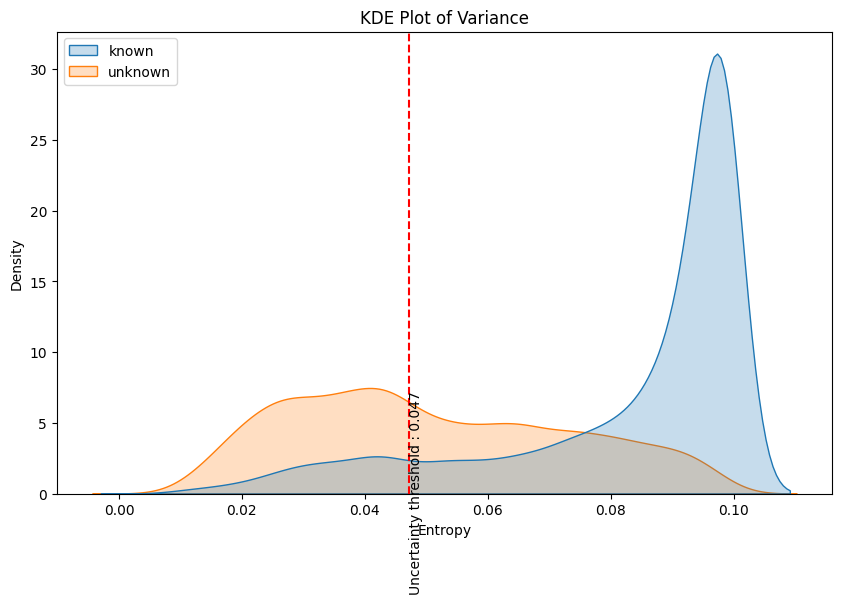

In [261]:
from scipy.stats import gaussian_kde
import seaborn as sns
var_full = np.concatenate((var_known, var_unknown)) # we combine them for a better looking plot
all_y_test = np.concatenate([Y_test_known, Y_unknown])
all_y_test = np.array(["known" if i < n_classes else "unknown" for i in all_y_test])

kde_known = gaussian_kde(var_full[np.array(all_y_test) == "known"])
kde_unknown = gaussian_kde(var_full[np.array(all_y_test) == "unknown"])

uncertainty_threshold = np.percentile(var_known, 100-89)  #
plt.figure(figsize = (10, 6))
sns.kdeplot(x = var_full, hue = all_y_test, fill = True)
plt.axvline(uncertainty_threshold, color = "red", linestyle = "--")
plt.text(uncertainty_threshold, 0.1,
         f"Uncertainty threshold : {uncertainty_threshold:.3f}",
         rotation = 90, verticalalignment = "center")
plt.title("KDE Plot of Variance")
plt.xlabel("Entropy")
plt.ylabel("Density")
plt.show()

## Comparison with classical neural networks

To compare with a classical neural network, we face the issue that if we make 50 predictions, the result will be the same each time, providing no uncertainty estimate. To address this, we will use the same architecture as our Bayesian model but add a dropout layer that remains active during inference. This introduces variability in the predictions, allowing us to generate multiple samples.

We will then take some number of samples as in the Bayesian approach and calculate the class probabilities for each prediction. Finally, we will compute the entropy of these predictions to estimate uncertainty, similar to the process used for the Bayesian model. This comparison will help us assess how well the dropout-based method approximates uncertainty compared to the true Bayesian approach.

In [302]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.stats import entropy

class ClassicNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ClassicNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 64)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.softmax(self.fc3(x), dim=-1)
        return x

def predict_with_uncertainty(model, X, num_predictions=50):
    model.train()
    predictions = []

    with torch.no_grad():
        for _ in range(num_predictions):
            output = model(X)
            predictions.append(output.cpu().numpy())

    predictions = np.array(predictions)

    mean_pred = predictions.mean(axis=0)

    entropy_values = np.apply_along_axis(lambda x: entropy(x), axis=1, arr=mean_pred)

    return mean_pred, entropy_values, predictions

def compute_accuracy(model, X, Y):
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == Y).sum().item()
        accuracy = correct / Y.size(0)
    return accuracy

input_dim = 784
num_classes = n_classes

model = ClassicNN(input_dim, num_classes)

X_train_known_tensor = torch.tensor(X_train_known, dtype=torch.float32)
Y_train_known_tensor = torch.tensor(Y_train_known, dtype=torch.long)
X_test_known_tensor = torch.tensor(X_test_known, dtype=torch.float32)
Y_test_known_tensor = torch.tensor(Y_test_known, dtype=torch.long)
X_unknown_tensor = torch.tensor(X_unknown, dtype=torch.float32)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_known_tensor)
    loss = criterion(outputs, Y_train_known_tensor)
    loss.backward()
    optimizer.step()

accuracy_known = compute_accuracy(model, X_test_known_tensor, Y_test_known_tensor)
print(f"Accuracy on Known Test Set: {accuracy_known * 100:.2f}%")

mean_pred_known, entropies_known, predictions = predict_with_uncertainty(model, X_test_known_tensor, num_predictions=50)

mean_pred_unknown, entropies_unknown, _ = predict_with_uncertainty(model, X_unknown_tensor, num_predictions=50)

print("entropies for Known Test Set:\n", entropies_known)
print("entropies for Unknown Test Set:\n", entropies_unknown)



Accuracy on Known Test Set: 88.84%
entropies for Known Test Set:
 [0.0053967  0.08258698 0.2706049  ... 0.32675493 0.63665825 0.00792423]
entropies for Unknown Test Set:
 [0.861425   0.60958856 1.0037932  ... 0.37456366 0.3021564  0.10206886]


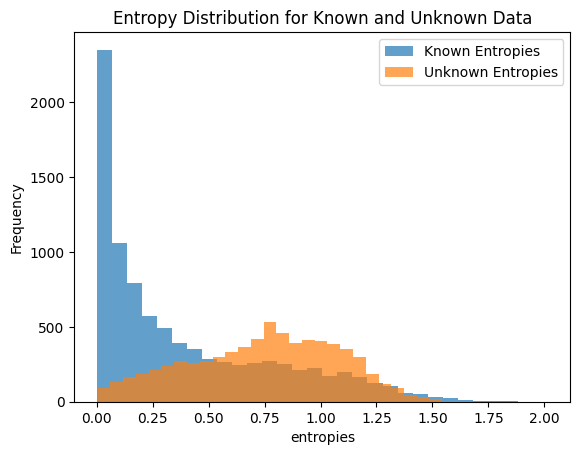

Uncertain samples in known data: 1169
Uncertain samples in unknown data: 2133


In [303]:
plt.hist(entropies_known, bins=30, alpha=0.7, label="Known Entropies")
plt.hist(entropies_unknown, bins=30, alpha=0.7, label="Unknown Entropies")
plt.xlabel("entropies")
plt.ylabel("Frequency")
plt.legend()
plt.title("Entropy Distribution for Known and Unknown Data")
plt.show()
uncertainty_threshold = np.percentile(entropies_known, 87)  #

uncertain_samples_known = entropies_known > uncertainty_threshold
uncertain_samples_unknown = entropies_unknown > uncertainty_threshold

print(f"Uncertain samples in known data: {np.sum(uncertain_samples_known)}")
print(f"Uncertain samples in unknown data: {np.sum(uncertain_samples_unknown)}")


In [304]:
mean_pred = predictions.mean(axis=0)
precitions_labels = np.argmax(mean_pred, 1)
predictions_copy = precitions_labels.copy()
predictions_copy[entropies_known > uncertainty_threshold]=-1
print(f"Accuracy of unknowns {np.sum(uncertain_samples_unknown)/len(Y_unknown)}")
print(f"Accuracy after verifying uncertainty on test data {np.mean(predictions_copy==Y_test_known)}")

Accuracy of unknowns 0.30655360735843634
Accuracy after verifying uncertainty on test data 0.8227116004893783


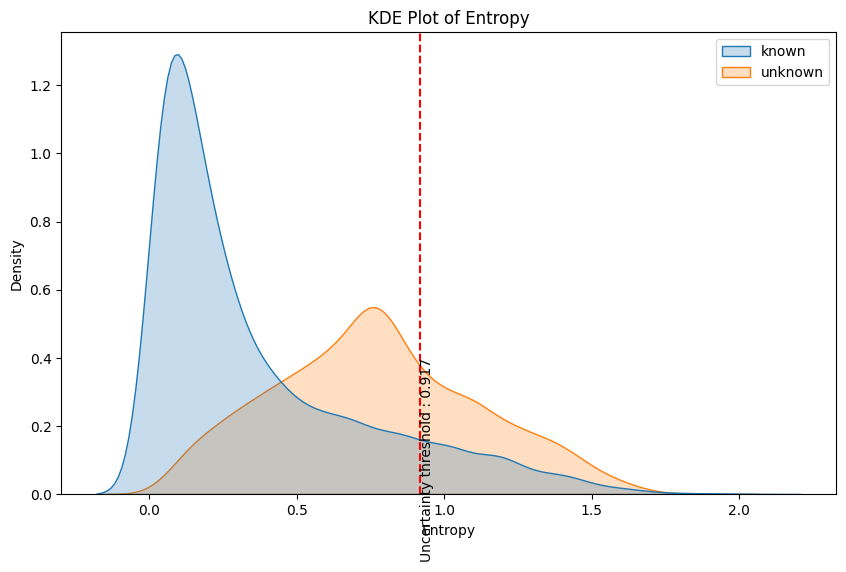

In [229]:
from scipy.stats import gaussian_kde
import seaborn as sns
entropies_full = np.concatenate((entropies_known, entropies_unknown)) # we combine them for a better looking plot
all_y_test = np.concatenate([Y_test_known, Y_unknown])
all_y_test = np.array(["known" if i < n_classes else "unknown" for i in all_y_test])

kde_known = gaussian_kde(entropies_full[np.array(all_y_test) == "known"])
kde_unknown = gaussian_kde(entropies_full[np.array(all_y_test) == "unknown"])

uncertainty_threshold = np.percentile(entropies_known, 89)  #
plt.figure(figsize = (10, 6))
sns.kdeplot(x = entropies_full, hue = all_y_test, fill = True)
plt.axvline(uncertainty_threshold, color = "red", linestyle = "--")
plt.text(uncertainty_threshold, 0.1,f"Uncertainty threshold : {uncertainty_threshold:.3f}",rotation = 90, verticalalignment = "center")
plt.title("KDE Plot of Entropy")
plt.xlabel("Entropy")
plt.ylabel("Density")
plt.show()

The convolutional neural network architecture demonstrated higher overall accuracy compared to the dense network. More importantly, it also showed superior performance on the primary task of uncertainty modeling. This suggests that the ability of convolutional layers to capture spatial features in images significantly enhances the model's capability to handle uncertainty.

For this experiment, we used a simple CNN architecture. While effective, there is considerable room for improvement. By employing more advanced architectural designs, such as deeper networks, additional convolutional layers, or optimized hyperparameters, it is likely that the performance can be further improved. These enhancements could lead to better accuracy both in general classification tasks and in uncertainty modeling, strengthening the model's robustness and reliability.

RESULTS:
$$
\
\begin{array}{|c|c|c|c|}
\hline
\textbf{Model} & \textbf{ACC} & \textbf{Var Uncertainty} & \textbf{Entropy uncertainty} \\
\hline
\textbf{BNN} & 0.92 & 0.337 & 0.32 \\
\textbf{Dropout-NN} & 0.888 & - & 0.3065 \\
\textbf{C-BNN} & 0.9471 & 0.4997 & 0.56 \\
\hline
\end{array}
$$

# Conclusion for classification



Overall, the Bayesian neural network (BNN) approach performed well, particularly in modeling uncertainty. While the dropout-based method worked reasonably well for approximating uncertainty, the Bayesian convolutional neural network (Bayesian CNN) was the standout performer, delivering the best results both in terms of classification accuracy and uncertainty estimation. This demonstrates the strength of Bayesian methods, especially when combined with convolutional architectures, in handling uncertainty in classification tasks. With further improvements to the architecture and fine-tuning, these models can offer even better results, particularly for tasks requiring reliable uncertainty quantification.

# REGRESSION


For the regression task, we will define a threshold over the input range to separate the data into interpolation and extrapolation regions. The model will be trained only on the interpolation region, and we will evaluate its performance outside this range. Unlike classification, we cannot use entropy or variance over probabilities, as regression does not involve class probabilities.

Instead, we will use two methods to measure uncertainty. First, we will examine the variance of the predictions, where higher variance indicates greater uncertainty. Second, we will analyze the Highest Density Interval (HDI), which represents the range containing the most credible values of the predictions, and visualize this to observe differences between the interpolation and extrapolation regions.

For this task, we will use a synthetic dataset representing a simple nonlinear regression problem.



# Regression Dataset creation




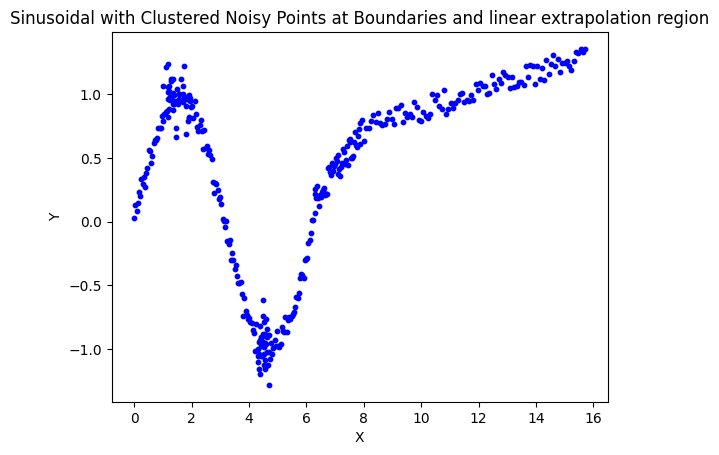

In [148]:
import numpy as np
import matplotlib.pyplot as plt

k = 150
w = 100
m = 50
n_points = 30

x_sin = np.linspace(0, 2 * np.pi, k)
y_sin = np.sin(x_sin) + np.random.normal(0, 0.05, len(x_sin))

x_top = np.random.uniform(1, 2, n_points)
y_top = np.full(n_points, 1) + np.random.normal(0, 0.15, n_points)

x_bottom = np.random.uniform(4.3, 4.7, n_points)
y_bottom = np.full(n_points, -1) + np.random.normal(0, 0.15, n_points)

transition_x = np.linspace(2 * np.pi, 2.5 * np.pi, m)
transition_y = np.linspace(y_sin[-1], y_sin[-1] + 0.5, len(transition_x)) + np.random.uniform(0, 0.2, m)

x_line = np.linspace(2.5 * np.pi, 5 * np.pi, w)
y_line = np.linspace(transition_y[-1], transition_y[-1] + 0.6, len(x_line)) + np.random.uniform(0, 0.2, w)  # Constant y value (no variation)

x_combined = np.concatenate([x_top, x_sin, x_bottom, transition_x, x_line])
y_combined = np.concatenate([y_top, y_sin, y_bottom, transition_y, y_line])
sorted_indices = np.argsort(x_combined)
x_train = x_combined[sorted_indices].reshape(-1, 1)  # Reshaped to 2D
y_train = y_combined[sorted_indices]
# plt.plot(x_train, y_train)
plt.scatter(x_combined, y_combined, color='blue', s=10)
plt.title('Sinusoidal with Clustered Noisy Points at Boundaries and linear extrapolation region')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


Because we don't have a large dataset for this task, we have no reason to use the minibatch so we won't have to do the trick with the rewriting the model for inference. Additionally, instead of ADVI, we can use NUTS sampling for better performance.
We will separate the interpolation and extrapolation regions now

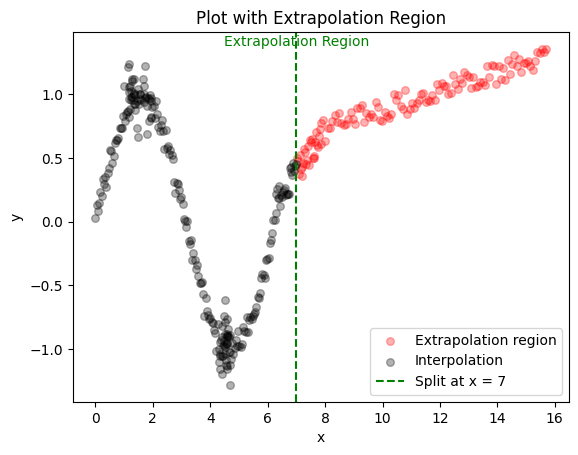

In [149]:
idxs = np.array([x_train<7]).flatten()
x = x_train[idxs]
y = y_train[idxs]
x_other = x_train[~idxs]
y_other = y_train[~idxs]

plt.scatter(x_other, y_other, color='red', label='Extrapolation region', s=30, alpha=0.3)
plt.scatter(x, y, color='black', label='Interpolation', s=30, alpha=0.3)

plt.axvline(x=7, color='green', linestyle='--', label='Split at x = 7')

plt.text(7, max(y_train), 'Extrapolation Region', color='green', ha='center', va='bottom')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot with Extrapolation Region')
plt.legend()

plt.show()


Now we make the regression model

In [150]:
def construct_nn_regression(ann_input, ann_output):
    n_hidden_1 = 8
    n_hidden_2 = 16
    n_hidden_3 = 32
    n_features = ann_input.eval().shape[1]

    init_1 = np.random.randn(n_features, n_hidden_1).astype(floatX)
    init_2 = np.random.randn(n_hidden_1, n_hidden_2).astype(floatX)
    init_3 = np.random.randn(n_hidden_2, n_hidden_3).astype(floatX)
    init_out = np.random.randn(n_hidden_3).astype(floatX)
    init_bias_1 = np.zeros(n_hidden_1).astype(floatX)
    init_bias_2 = np.zeros(n_hidden_2).astype(floatX)
    init_bias_3 = np.zeros(n_hidden_3).astype(floatX)
    init_bias_out = np.zeros(1).astype(floatX)

    with pm.Model() as neural_network:
        weights_in_1 = pm.Normal('w_in_1', mu=0, sigma=1, shape=(n_features, n_hidden_1), initval=init_1)
        weights_1_2 = pm.Normal('w_1_2', mu=0, sigma=1, shape=(n_hidden_1, n_hidden_2), initval=init_2)
        weights_2_3 = pm.Normal('w_2_3', mu=0, sigma=1, shape=(n_hidden_2, n_hidden_3), initval=init_3)
        weights_3_out = pm.Normal('w_3_out', mu=0, sigma=1, shape=(n_hidden_3), initval=init_out)

        biases_1 = pm.Normal('b_1', mu=0, sigma=1, shape=(n_hidden_1,), initval=init_bias_1)
        biases_2 = pm.Normal('b_2', mu=0, sigma=1, shape=(n_hidden_2,), initval=init_bias_2)
        biases_3 = pm.Normal('b_3', mu=0, sigma=1, shape=(n_hidden_3,), initval=init_bias_3)
        bias_out = pm.Normal('b_out', mu=0, sigma=1, shape=(1,), initval=init_bias_out)

        act_1 = leakyrelu(pm.math.dot(ann_input, weights_in_1) + biases_1,0.3)
        act_2 = leakyrelu(pm.math.dot(act_1, weights_1_2) + biases_2,0.3)
        act_3 = leakyrelu(pm.math.dot(act_2, weights_2_3) + biases_3,0.3)
        act_out = pm.math.dot(act_3, weights_3_out) + bias_out

        sigma = pm.HalfNormal('sigma', sigma=1)
        out = pm.Normal('out', mu=act_out, sigma=sigma, observed=ann_output)

    return neural_network

In [151]:
ann_input = pt.shared(x)
ann_output = pt.shared(y)
neural_net = construct_nn_regression(ann_input, ann_output)

In [152]:
with neural_net:
  trace = pm.sample(draws=1000, tune=500, chains=1, target_accept=0.95)

Output()

In [153]:
with neural_net:
  ppc = pm.sample_posterior_predictive(trace, var_names=["out"])

Output()

In [154]:
results = ppc.posterior_predictive['out'][0].values

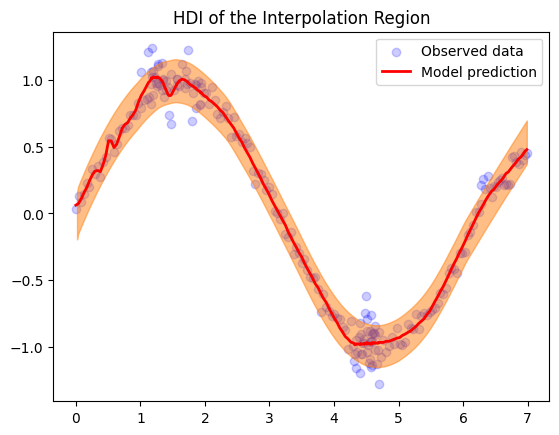

In [216]:
plt.scatter(x, y, color="blue", label="Observed data", alpha=0.2)
plt.plot(x, results.mean(0), color="red", label="Model prediction", linewidth=2)

ax = az.plot_hdi(x.flatten(), results[None,:], hdi_prob=0.9)
plt.title("HDI of the Interpolation Region")

plt.legend()
plt.show()


# Now we predict outside of the interpolation region

In [156]:
range_extra = np.linspace(7, 10, 200).reshape(-1, 1)
with neural_net:
  ann_input.set_value(range_extra)
  ann_output.set_value(np.zeros(range_extra.shape[0]))
  ppc_predicts = pm.sample_posterior_predictive(trace)
results_predicts = ppc_predicts.posterior_predictive['out'][0].values

Output()

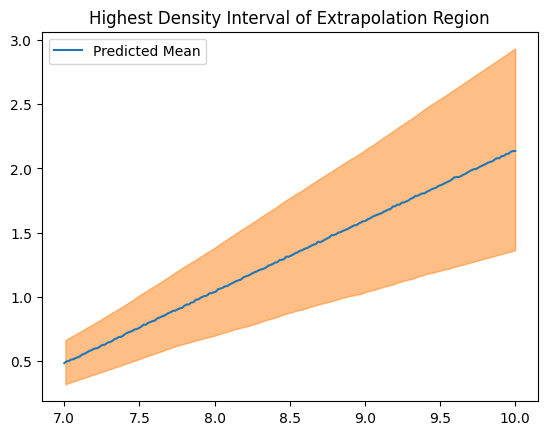

In [157]:
import matplotlib.pyplot as plt
import arviz as az

plt.plot(range_extra, results_predicts.mean(0), label="Predicted Mean")
az.plot_hdi(range_extra.flatten(), results_predicts[None,:], hdi_prob=0.9)
plt.title("Highest Density Interval of Extrapolation Region")
plt.legend()


<Axes: >

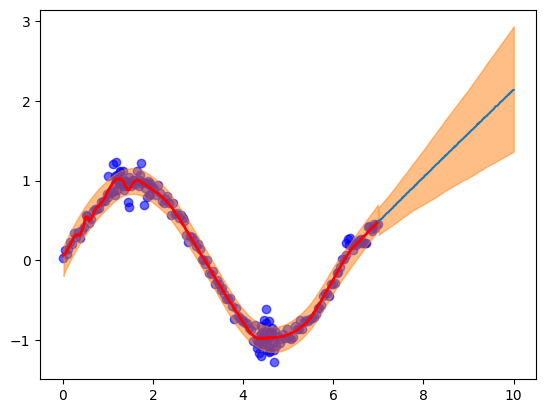

In [158]:
results = ppc.posterior_predictive["out"][0].values

plt.scatter(x, y, color="blue", label="Observed data", alpha=0.6)
plt.plot(x, results.mean(0), color="red", label="Model prediction (ADVI)", linewidth=2)
ax = az.plot_hdi(x.flatten(), results[None,:], hdi_prob=0.9)
plt.plot(range_extra,results_predicts.mean(0))
az.plot_hdi(range_extra.flatten(), results_predicts[None,:], hdi_prob=0.9)


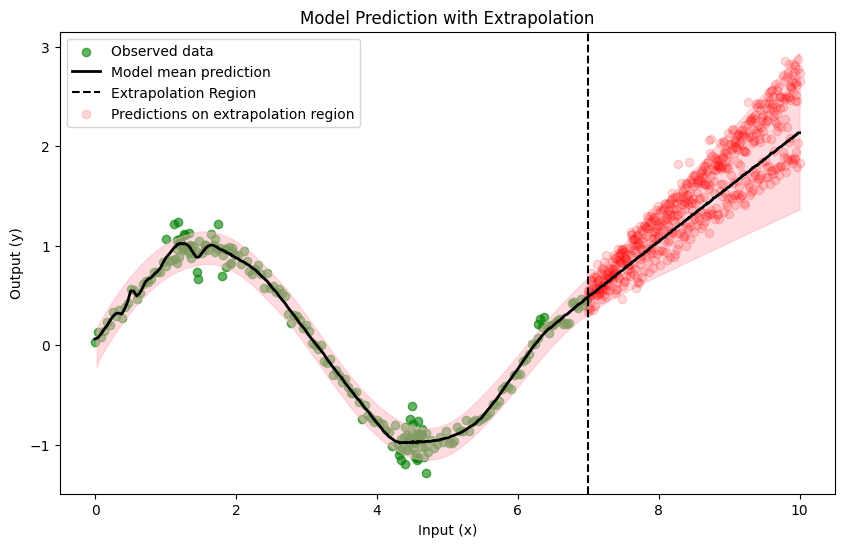

In [238]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

x_combined = np.vstack([x, range_extra])

results_combined_mean = np.concatenate([
    results.mean(0),
    results_predicts.mean(0)
])

combined_hdi = np.column_stack([results, results_predicts])[None, :]

plt.figure(figsize=(10, 6))

plt.scatter(x, y, color="green", label="Observed data", alpha=0.6)

plt.plot(x_combined, results_combined_mean, color="black", label="Model mean prediction", linewidth=2)

az.plot_hdi(x_combined.flatten(), combined_hdi, hdi_prob=0.9, color='lightpink')

plt.axvline(x=7, color='black', linestyle='--', label="Extrapolation Region")
plt.scatter(range_extra, results_predicts[193], color='red', alpha=0.15)
plt.scatter(range_extra, results_predicts[0], color='red', alpha=0.15, label='Predictions on extrapolation region')
plt.xlabel("Input (x)")
plt.ylabel("Output (y)")
plt.title("Model Prediction with Extrapolation")

plt.legend()

plt.show()


We can observe that after the boundary line we have a higher density of model predictions extending into the extrapolation region. In the observed region (to the left of the line), the data points closely follow the model's predictions, with the highest density of observations near the lower values of
x. However, once we move beyond the boundary, into the extrapolation region (to the right of the line), there is an increased spread in the predicted values, indicating greater uncertainty in the model’s predictions as it moves further from the observed data range. The model's predictions become more uncertain as they go into this extrapolated space, which is reflected by the wider confidence intervals (HDI) in the extrapolation region.

In [203]:
variance_results = np.var(results.T, axis=1)
variance_extrapolation = np.var(results_predicts.T, axis=1)

In [215]:
print(f'"Variance of a point in the interpolation region: {np.mean(variance_results)} vs Variance of a point in the extrapolation region  {np.mean(variance_extrapolation)}')

"Variance of a point in the interpolation region: 0.009836224503872885 vs Variance of a point in the extrapolation region  0.11511047937465457


We can also look at the variance of the predictions of the model. As we can see in the result, a point in the extrapolation region has a variance of predictions way bigger than the point in the interpolation region, meaning that the model is not very sure of his predictions on the extrapolation region, without being trained to know where is the extrapolation region exactl

# Conclusion for regression

The Bayesian approach to regression also proved effective in modeling uncertainty. By utilizing the Highest Density Interval (HDI) and variance of predictions, we were able to assess uncertainty in both interpolation and extrapolation regions. The methods worked well in distinguishing areas where the model was more confident from those with greater uncertainty.

# Conclusion

Bayesian neural networks (BNNs) prove to be an excellent tool for modeling uncertainty across both classification and regression tasks. By providing a distribution over predictions, BNNs allow for more nuanced uncertainty estimation, which is crucial for tasks that involve decision-making under uncertainty. Whether it's through entropy, variance, or the Highest Density Interval (HDI), BNNs offer robust methods for quantifying uncertainty, leading to more reliable and interpretable models. Their ability to handle uncertainty makes them particularly valuable in real-world applications where knowing the confidence of predictions is just as important as the predictions themselves.